# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import math
import random

import gym
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Show Actor network

In [6]:
from torchviz import make_dot, make_dot_from_trace
from torchviz import make_dot
from torch.autograd import Variable

from agent import *

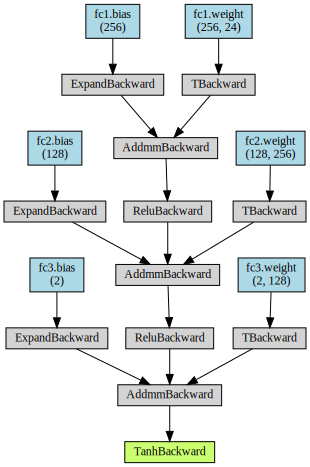

In [7]:
actor_model = Actor(state_size, action_size, 0)
x = Variable(torch.randn(1, state_size))
y = actor_model(x)

make_dot(y, params=dict(list(actor_model.named_parameters())))

### 4. Show Critic network

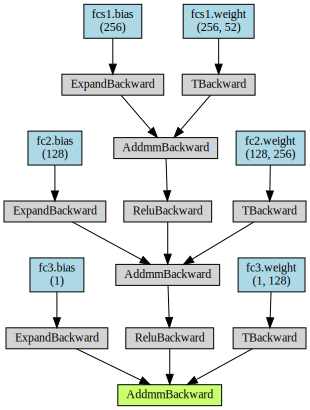

In [8]:
critic_model = Critic(state_size, action_size, num_agents, 0)
states = Variable(torch.randn(1, state_size*num_agents))
actions = Variable(torch.randn(1, action_size*num_agents))

y = critic_model(states, actions)

make_dot(y, params=dict(list(critic_model.named_parameters())))

### 5. Create the agents

In [9]:
from agent import MADDPG

agent = MADDPG(state_size, action_size, num_agents, random_seed=0)

In [10]:
def maddpg(n_episodes=10000):
    scores_mean = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_episodes+1):                       
        average_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations            
        scores_agents = np.zeros(num_agents)        
        
        agent.reset()

        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones)
                
            states = next_states
            scores_agents += rewards            
            
            if np.any(dones):
                break

        score = scores_agents.max()
        
        scores.append(score)
        scores_mean.append(score)
        average_score = np.mean(scores_mean)        
        
        print("\rEpisode: {:5d}, Average Score: {:.3f}".format(i_episode, average_score), end='')

        if i_episode % 100 == 0:
            print("\rEpisode: {:5d}, Average Score: {:.3f}".format(i_episode, average_score))
            
        if average_score > 0.5:
            print("\rSolved in episode: {:5d}, Average Score: {:.3f}".format(i_episode, average_score))
            
            agent.save_weights()               
            break

    return scores, scores_mean

scores, average_scores = maddpg()

Episode:   100, Average Score: 0.007
Episode:   200, Average Score: 0.000
Episode:   300, Average Score: 0.000
Episode:   400, Average Score: 0.000
Episode:   500, Average Score: 0.008
Episode:   600, Average Score: 0.014
Episode:   700, Average Score: 0.030
Episode:   800, Average Score: 0.015
Episode:   900, Average Score: 0.039
Episode:  1000, Average Score: 0.057
Episode:  1100, Average Score: 0.090
Episode:  1200, Average Score: 0.133
Episode:  1300, Average Score: 0.124
Episode:  1400, Average Score: 0.149
Episode:  1500, Average Score: 0.231
Episode:  1600, Average Score: 0.334
Episode:  1700, Average Score: 0.434
Episode:  1800, Average Score: 0.488
Episode:  1900, Average Score: 0.433
Solved in episode:  1943, Average Score: 0.500


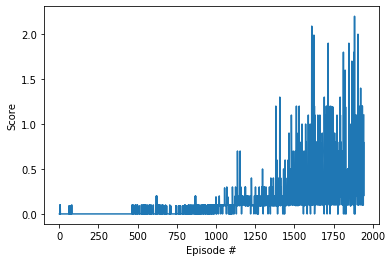

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

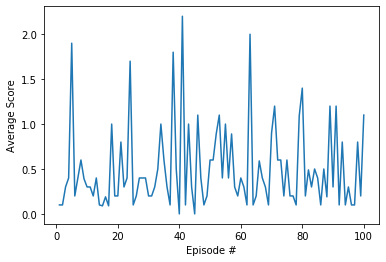

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [13]:
env.close()